In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pzflow import Flow
from utils import LSSTErrorModel

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the flow

In [3]:
flow = Flow(file="saved-flows/desc-dc2-redshift-flow.pkl")

Sample from the flow and add LSST errors

In [4]:
samples = flow.sample(10000, seed=0)

s = LSSTErrorModel()(samples, seed=0)
s = s.query("u < 90 & g < 90 & r < 90 & i < 90 & z < 90 & y < 90 & redshift < 1.7")

Pull out the one galaxy I want to make a plot for. Determined from the `expectation_value_is_better` notebook.

In [5]:
idx = 21
gal_true = samples.iloc[s.index[idx:idx+1]]
gal_err = s.iloc[idx:idx+1]

In [6]:
gal_true

,redshift,u,g,r,i,z,y
43,0.417122,25.942293,25.300163,24.284489,23.938671,23.72274,23.56682


In [7]:
gal_err

,redshift,u,g,r,i,z,y,u_err,g_err,r_err,i_err,z_err,y_err
43,0.417122,26.077956,25.300612,24.277591,23.936875,23.694079,23.563667,0.173635,0.030978,0.012495,0.016497,0.024513,0.005639


Calculate the posteriors

In [8]:
grid = np.arange(0.25, 0.55, 0.001)
pdf_true = flow.posterior(gal_true, grid=grid, column="redshift")[0]
pdf_err = flow.posterior(gal_err, grid=grid, column="redshift")[0]

In [13]:
%%time
# draw samples from the error distribution
N = 5000
# calculate pdf for each sample
pdf_convolved = flow.posterior(gal_err, grid=grid, column="redshift", nsamples=N, seed=1)[0]

CPU times: user 58.4 s, sys: 2min 32s, total: 3min 30s
Wall time: 25.6 s


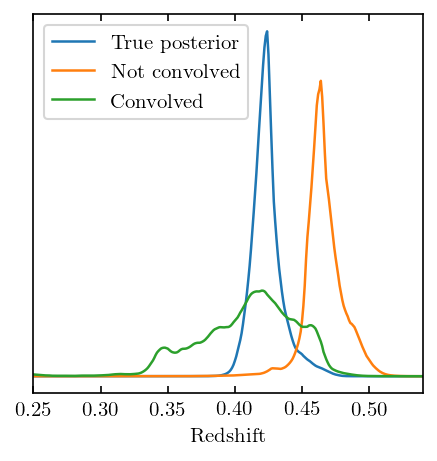

In [14]:
fig, ax = plt.subplots()
ax.plot(grid, pdf_true, label="True posterior")
ax.plot(grid, pdf_err, label="Not convolved")
ax.plot(grid, pdf_convolved, label="Convolved")
ax.legend()
ax.set(xlim=(0.25, 0.54), xlabel="Redshift", yticks=[])
plt.show()

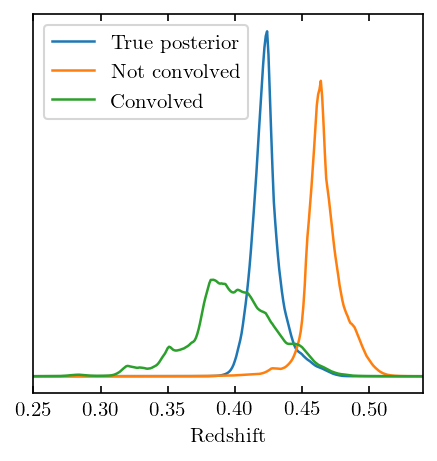

In [12]:
fig, ax = plt.subplots()
ax.plot(grid, pdf_true, label="True posterior")
ax.plot(grid, pdf_err, label="Not convolved")
ax.plot(grid, pdf_convolved, label="Convolved")
ax.legend()
ax.set(xlim=(0.25, 0.54), xlabel="Redshift", yticks=[])
plt.show()

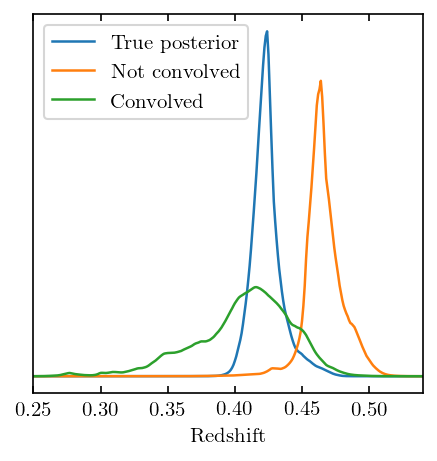

In [10]:
fig, ax = plt.subplots()
ax.plot(grid, pdf_true, label="True posterior")
ax.plot(grid, pdf_err, label="Not convolved")
ax.plot(grid, pdf_convolved, label="Convolved")
ax.legend()
ax.set(xlim=(0.25, 0.54), xlabel="Redshift", yticks=[])
plt.show()

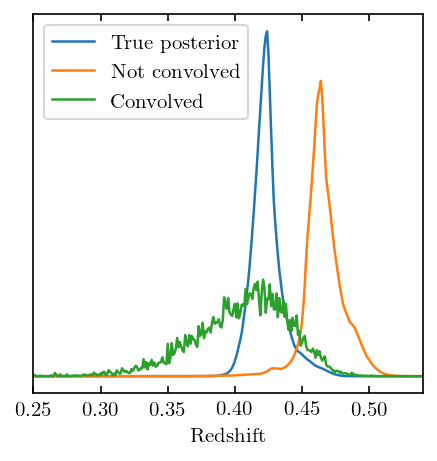

In [16]:
fig, ax = plt.subplots()
ax.plot(grid, pdf_true, label="True posterior")
ax.plot(grid, pdf_err, label="Not convolved")
ax.plot(grid, pdf_convolved, label="Convolved")
ax.legend()
ax.set(xlim=(0.25, 0.54), xlabel="Redshift", yticks=[])
plt.show()

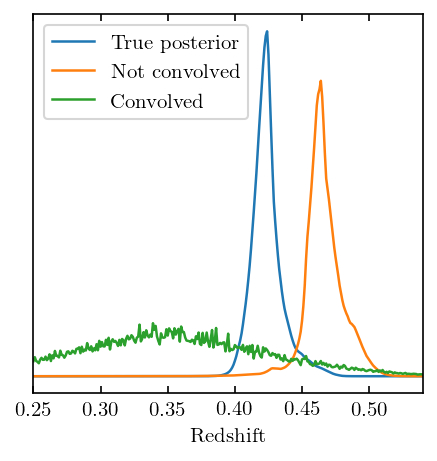

In [22]:
fig, ax = plt.subplots()
ax.plot(grid, pdf_true, label="True posterior")
ax.plot(grid, pdf_err, label="Not convolved")
ax.plot(grid, pdf_convolved, label="Convolved")
ax.legend()
ax.set(xlim=(0.25, 0.54), xlabel="Redshift", yticks=[])
plt.show()

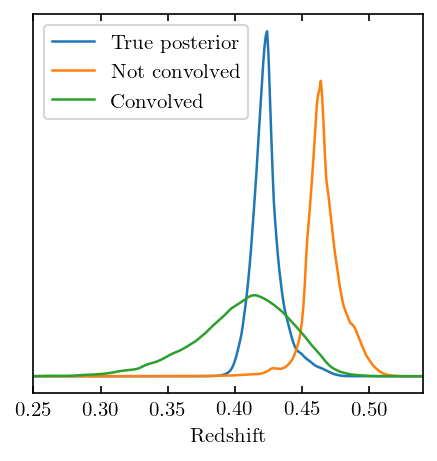

In [8]:
fig, ax = plt.subplots()
ax.plot(grid, pdf_true, label="True posterior")
ax.plot(grid, pdf_err, label="Not convolved")
ax.plot(grid, pdf_convolved, label="Convolved")
ax.legend()
ax.set(xlim=(0.25, 0.54), xlabel="Redshift", yticks=[])
plt.show()

Now I want to marginalize over the u band

First let's plot u-g to see what values of u we should consider given the measured g

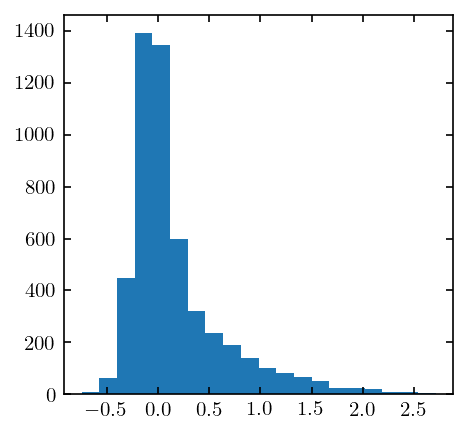

In [159]:
fig, ax = plt.subplots()
ax.hist(s["u"] - s["g"], bins=20)
ax.set(xticks=[-0.5, 0, 0.5, 1, 1.5, 2, 2.5]);

Let's look at the u posterior without error convolution, with redshift marginalized

In [172]:
%%time
# draw samples from the error distribution
N = 100
rng = np.random.default_rng(0)
g = gal_err["g"].values[0]
ugrid = np.linspace(g-0.5, g+2, N)
u_samples = np.hstack((
    np.repeat(gal_err.iloc[0,0], N).reshape(-1, 1),
    ugrid.reshape(-1, 1),
    np.tile(gal_err.iloc[0,2:7], N).reshape(-1, 5),
))
u_samples = pd.DataFrame(u_samples, columns=samples.columns)

# calculate pdf for each sample
updf_samples = flow.posterior(u_samples, grid=grid, column="redshift", normalize=False)
# average pdfs
updf = updf_samples.sum(axis=1)
updf /= updf.sum() * (ugrid[1] - ugrid[0])

CPU times: user 1.65 s, sys: 1.91 s, total: 3.56 s
Wall time: 642 ms


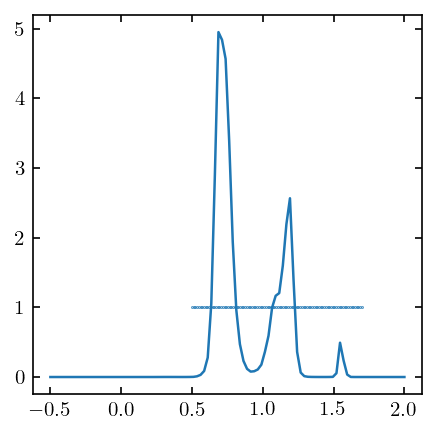

In [183]:
plt.plot(ugrid-gal_err["g"].values, updf)
plt.scatter(np.linspace(0.5, 1.7, 100), np.ones(100), s=0.1)

Okay let's now marginalize over u while convolving errors:

In [208]:
%%time
# draw samples from the error distribution
N = 10000
rng = np.random.default_rng(0)
g = gal_err["g"].values[0]
ugrid = np.linspace(g+0.5, g+1.7, 100)
ugal_samples = []
for u in ugrid:
    ugal_samples.append(np.hstack((
        np.repeat(gal_err.iloc[0,0], N).reshape(-1, 1),
        np.repeat(u, N).reshape(-1, 1),
        rng.normal(gal_err.iloc[0, 2:7], gal_err.iloc[0, 8:], size=(N, 5))
    )))
ugal_samples = np.array(ugal_samples).reshape(-1, 7)
ugal_samples = pd.DataFrame(ugal_samples, columns=samples.columns)

# calculate pdf for each sample
grid2 = np.arange(0.15, 0.55, 0.001)
pdf_samples_umarg = flow.posterior(ugal_samples, grid=grid2, column="redshift", normalize=False)
# average pdfs
pdf_convolved_umarg = pdf_samples_umarg.sum(axis=0)
pdf_convolved_umarg /= pdf_convolved_umarg.sum() * (grid2[1] - grid2[0])

CPU times: user 3h 11min, sys: 12h 43min 31s, total: 15h 54min 32s
Wall time: 1h 22min 32s


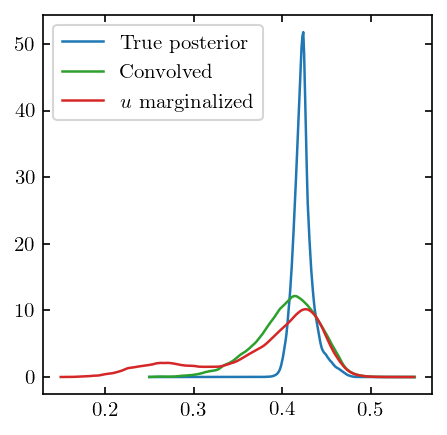

In [209]:
fig, ax = plt.subplots()
ax.plot(grid, pdf_true, label="True posterior")
ax.plot(grid, pdf_convolved, label="Convolved", c="C2")
ax.plot(grid2, pdf_convolved_umarg, label="$u$ marginalized", c="C3")
ax.legend()
#ax.set(xlim=(0.25, 0.54), xlabel="Redshift", yticks=[])
plt.show()

Make one plot for the posteriors

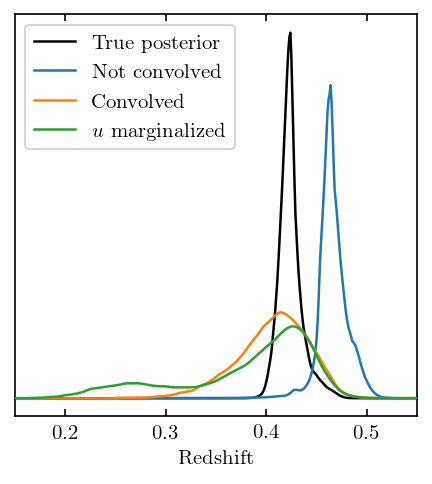

In [279]:
fig, ax = plt.subplots()

# plot posteriors
ax.plot(grid, pdf_true, label="True posterior", c="k", zorder=0)
ax.plot(grid, pdf_err, label="Not convolved", c="C0", zorder=1)
ax.plot(grid, pdf_convolved, label="Convolved", c="C1", zorder=2)
ax.plot(grid2, pdf_convolved_umarg, label="$u$ marginalized", c="C2", zorder=3)

# plot extensions to bottom of xlim
ax.plot([0.15, 0.25], [0, 0], c="k", zorder=0)
ax.plot([0.15, 0.25], [0, 0], c="C0", zorder=1)
ax.plot([0.15, 0.25], [0, 0], c="C1", zorder=2)

ax.legend()
ax.set(xlabel="Redshift", yticks=[], xlim=(0.15, 0.55))

plt.subplots_adjust(bottom=0.15, top=0.95, left=0.10, right=0.90)

fig.savefig("figures/posteriors.pdf")

In [13]:
x = np.array([[[1,2,3], [1,2,3]], [[10,11,12],[22,33,44]]])

In [14]:
x.shape

(2, 2, 3)

In [22]:
x.sum(axis=1) / (x.sum(axis=1).sum(axis=1)).reshape(-1,1)

array([[0.16666667, 0.33333333, 0.5       ],
       [0.24242424, 0.33333333, 0.42424242]])

In [20]:
x.sum(axis=1).sum(axis=1)

array([ 12, 132])

In [21]:
x.sum(axis=1)

array([[ 2,  4,  6],
       [32, 44, 56]])

In [23]:
0.16666667 + 0.33333333

0.5

In [25]:
x = np.array([[1,2,3,4],[5,6,7,8]])

In [30]:
np.repeat(x[:,2:], 3, axis=0)

array([[3, 4],
       [3, 4],
       [3, 4],
       [7, 8],
       [7, 8],
       [7, 8]])

In [29]:
np.repeat?

Signature: np.repeat(a, repeats, axis=None)
Docstring:
Repeat elements of an array.

Parameters
----------
a : array_like
    Input array.
repeats : int or array of ints
    The number of repetitions for each element.  `repeats` is broadcasted
    to fit the shape of the given axis.
axis : int, optional
    The axis along which to repeat values.  By default, use the
    flattened input array, and return a flat output array.

Returns
-------
repeated_array : ndarray
    Output array which has the same shape as `a`, except along
    the given axis.

See Also
--------
tile : Tile an array.
unique : Find the unique elements of an array.

Examples
--------
>>> np.repeat(3, 4)
array([3, 3, 3, 3])
>>> x = np.array([[1,2],[3,4]])
>>> np.repeat(x, 2)
array([1, 1, 2, 2, 3, 3, 4, 4])
>>> np.repeat(x, 3, axis=1)
array([[1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4]])
>>> np.repeat(x, [1, 2], axis=0)
array([[1, 2],
       [3, 4],
       [3, 4]])
File:      ~/.conda/envs/pzflow/lib/python3.9/site-pac

In [32]:
print(gal_true)

    redshift          u          g          r          i         z         y
43  0.417122  25.942293  25.300163  24.284489  23.938671  23.72274  23.56682


In [19]:
x = np.arange(int(1e6)).reshape(-1, 10)

In [21]:
x = pd.DataFrame(x)

In [25]:
%timeit np.array(x.values)

1.59 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
a = [1,2,3,4,5]

In [26]:
a.remove(2)
a.remove(4)

In [24]:
a

[1, 3, 4, 5]

In [15]:
x = np.arange(20).reshape(4, 5)
x = pd.DataFrame(x)

In [16]:
x

,0,1,2,3,4
0,0,1,2,3,4
1,5,6,7,8,9
2,10,11,12,13,14
3,15,16,17,18,19


In [25]:
x.iloc[[1,2,0,3]].values

array([[ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [ 0,  1,  2,  3,  4],
       [15, 16, 17, 18, 19]])